In [16]:
import nltk
nltk.download('stopwords')
import pandas as pd
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter


PATH = r"C:\Users\shoma\OneDrive\Рабочий стол\pract\out_reviews\dataset_reviews.csv"
df = pd.read_csv(PATH, encoding="utf-8-sig")

text_col = None
for c in ["Текст отзыва", "text", "review_text", "snippet"]:
    if c in df.columns:
        text_col = c
        break
if text_col is None:
    raise RuntimeError("Не найдена колонка с текстом отзыва.")

pos = df[pd.to_numeric(df["Рейтинг"], errors="coerce") >= 4]
neg = df[pd.to_numeric(df["Рейтинг"], errors="coerce") <= 2]

stop_ru = set(stopwords.words("russian"))
custom_stops = {
    "гостиница","отель","номер","номера","отзыв","отзывы","очень","приехали","спасибо",
    "были","был","была","это","всё","все","так","ещё","нам","нас","вам","нас","есть",
    "т","д","м","—","...",".."
}
stop_all = stop_ru | custom_stops

# Простая очистка текста
def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"[^А-Яа-яA-Za-zЁё\s]", " ", s)   # оставляем только буквы и пробел
    s = re.sub(r"\s+", " ", s).strip()
    return s

def texts_to_corpus(series: pd.Series) -> str:
    cleaned = series.fillna("").astype(str).map(clean_text)
    tokens = []
    for t in cleaned:
        tokens.extend([w for w in t.split() if w not in stop_all and len(w) > 2])
    return " ".join(tokens)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shoma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


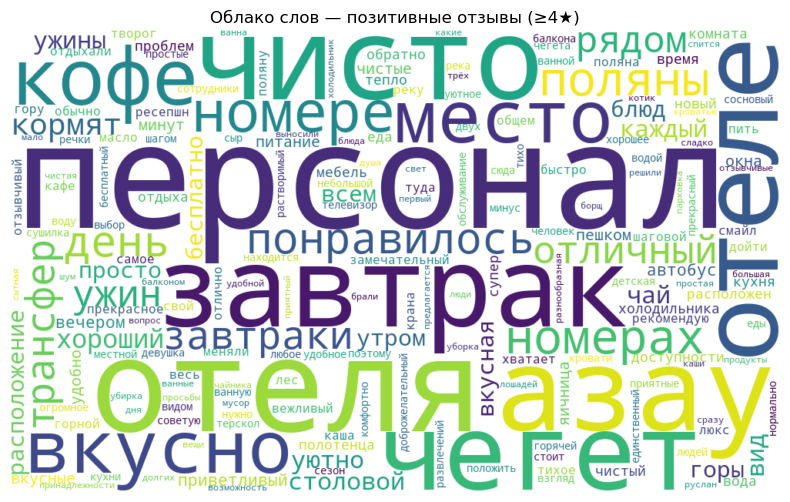

In [17]:
corpus_pos = texts_to_corpus(pos[text_col])

wc_pos = WordCloud(
    width=1000, height=600,
    background_color="white",
    collocations=False,
    prefer_horizontal=0.9
).generate(corpus_pos)

plt.figure(figsize=(10,6))
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Облако слов — позитивные отзывы (≥4★)")
plt.show()


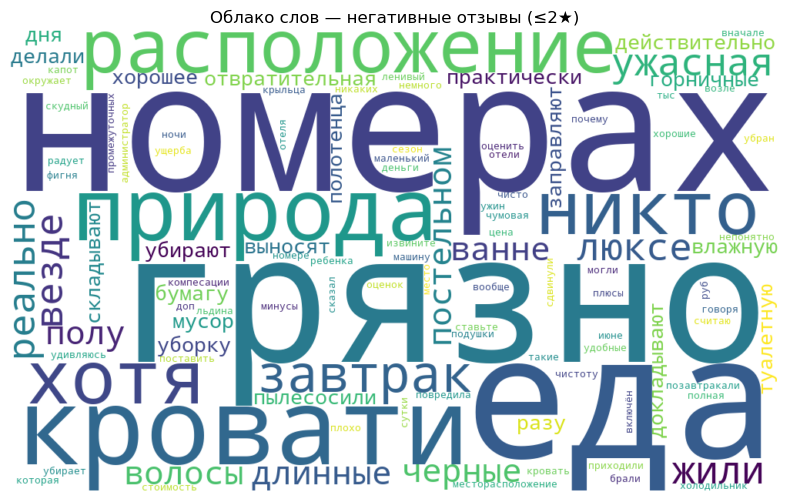

In [18]:
corpus_neg = texts_to_corpus(neg[text_col])

wc_neg = WordCloud(
    width=1000, height=600,
    background_color="white",
    collocations=False,
    prefer_horizontal=0.9
).generate(corpus_neg)

plt.figure(figsize=(10,6))
plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Облако слов — негативные отзывы (≤2★)")
plt.show()


In [ ]:
PATH = r"C:\Users\shoma\OneDrive\Рабочий стол\pract\out_reviews\dataset_reviews.csv"
df = pd.read_csv(PATH, encoding="utf-8-sig")


text_col = None
for c in ["Текст отзыва", "text", "review_text", "snippet"]:
    if c in df.columns:
        text_col = c
        break
if text_col is None:
    raise RuntimeError("Не найдена колонка с текстом отзыва.")


pos = df[pd.to_numeric(df["Рейтинг"], errors="coerce") >= 4].copy()
neg = df[pd.to_numeric(df["Рейтинг"], errors="coerce") <= 2].copy()


stop_ru = set(stopwords.words("russian"))
custom_stops = {
    "гостиница","отель","номер","номера","отзыв","отзывы","очень","приехали","спасибо",
    "были","был","была","это","всё","все","так","ещё","нам","нас","вам","есть",
    "просто","будто","типа","вообще","могли","мог","могла",
}
STOP = stop_ru | custom_stops

def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"[^а-яёa-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tokenize_series(series: pd.Series):
    """Возвращает список токенов для всей серии (без стоп-слов, токены длиной ≥3)."""
    toks = []
    for t in series.fillna("").astype(str).map(clean_text):
        toks.extend([w for w in t.split() if w not in STOP and len(w) >= 3])
    return toks


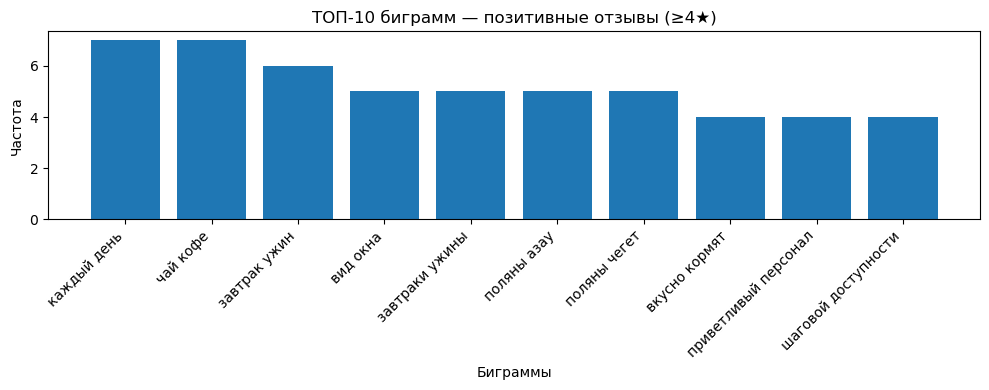

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

def top_bigrams(series: pd.Series, topk=10):
    corpus = series.fillna("").astype(str).map(clean_text).tolist()
    analyzer_stop = list(STOP)
    cv = CountVectorizer(
        ngram_range=(2,2),
        token_pattern=r"(?u)\b[а-яёa-z]{3,}\b",
        stop_words=analyzer_stop
    )
    X = cv.fit_transform(corpus)
    freqs = X.sum(axis=0).A1
    vocab = cv.get_feature_names_out()
    pairs = list(zip(vocab, freqs))
    pairs.sort(key=lambda x: x[1], reverse=True)
    return pairs[:topk]

# Позитивные биграммы
pos_bi = top_bigrams(pos[text_col], topk=10)
pos_bi_labels, pos_bi_counts = zip(*pos_bi) if pos_bi else ([], [])

plt.figure(figsize=(10,4))
plt.bar(pos_bi_labels, pos_bi_counts)
plt.title("ТОП-10 биграмм — позитивные отзывы (≥4★)")
plt.xlabel("Биграммы")
plt.ylabel("Частота")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
